
# **Project: Supply Chain Demand Forecasting Using Machine Learning**

## **Introduction**

Accurate demand forecasting is critical for supply chain optimization, helping businesses reduce inventory costs, avoid stockouts, and improve customer satisfaction. This project leverages historical retail sales data to build predictive models that forecast product demand at the store level. Using advanced machine learning techniques like XGBoost and CatBoost, the goal is to generate accurate sales predictions that can inform inventory management decisions.

---

## **Objective**

* Develop a robust demand forecasting model to predict daily sales for various products across stores.
* Engineer relevant time series and promotional features from transactional data.
* Use machine learning models (XGBoost and CatBoost) to capture complex patterns in sales data.
* Blend predictions from both models to improve accuracy.
* Evaluate model performance using key metrics like RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error).
* Deliver actionable insights for supply chain optimization.

---

## **Findings**

* Data preprocessing included merging transaction, product, and coupon datasets, and creating time-related features (day of week, month, year).
* Lag features (sales from previous days) and rolling statistics (mean, std over past windows) were crucial to capture temporal dependencies.
* Both XGBoost and CatBoost models were trained and validated using early stopping to avoid overfitting.
* Model tuning (hyperparameter optimization) improved prediction accuracy substantially.
* A blended model, averaging XGBoost and CatBoost predictions, achieved the best validation RMSE of approximately 1066.7 and MAE of 757.5, outperforming individual models.
* Feature importance analysis highlighted that recent sales lag features and promotional campaign indicators significantly influenced demand.

---

## **Conclusion**

The project demonstrates how combining gradient boosting models with thoughtful feature engineering can effectively forecast product demand in retail. The blended model’s accuracy indicates its potential value for supply chain managers to optimize inventory, reduce costs, and improve service levels. Future work could extend to integrating external factors like holidays or weather data, and deploying the model as a real-time forecasting tool.

---

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from prophet import Prophet

In [2]:
# Load train and test
train = pd.read_csv(r"D:\rossmann-store-sales\train.csv", parse_dates=['Date'],low_memory=False)
test = pd.read_csv(r"D:\rossmann-store-sales\test.csv", parse_dates=['Date'],low_memory=False)

# Store info for merging
store = pd.read_csv(r"D:\rossmann-store-sales\store.csv")

# Merge store info into train and test
train = train.merge(store, on='Store', how='left')
test = test.merge(store, on='Store', how='left')

In [3]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
train = train.drop(columns='DayOfWeek')


In [5]:
train.dtypes

Store                                 int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

In [6]:
# Sort data
# Remove closed stores

train = train[train['Sales'] > 0]
train = train.sort_values(['Store', 'Date'])
test = test.sort_values(['Store', 'Date'])

In [7]:
# Creating more features from Date column
def create_features(df):
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Day'] = df['Date'].dt.day
    return df



train = create_features(train)
test = create_features(test)

In [8]:
train.head(2)

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,WeekOfYear,Month,Year,Day
1014980,1,2013-01-02,5530,668,1,0,0,1,c,a,...,2008.0,0,NaN,NaN,NaN,2,1,1,2013,2
1013865,1,2013-01-03,4327,578,1,0,0,1,c,a,...,2008.0,0,NaN,NaN,NaN,3,1,1,2013,3


In [9]:
# Add Lag features - previous day and previous week sales

def add_lag_features(df):
    df = df.sort_values(['Store', 'Date'])
    df['Sales_lag_1'] = df.groupby('Store')['Sales'].shift(1)
    df['Sales_lag_7'] = df.groupby('Store')['Sales'].shift(7)
    return df

train = add_lag_features(train)
train[['Sales_lag_1', 'Sales_lag_7']] = train[['Sales_lag_1', 'Sales_lag_7']].fillna(0)

In [10]:
train.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,WeekOfYear,Month,Year,Day,Sales_lag_1,Sales_lag_7
1014980,1,2013-01-02,5530,668,1,0,0,1,c,a,...,NaN,NaN,NaN,2,1,1,2013,2,0.0,0.0
1013865,1,2013-01-03,4327,578,1,0,0,1,c,a,...,NaN,NaN,NaN,3,1,1,2013,3,5530.0,0.0
1012750,1,2013-01-04,4486,619,1,0,0,1,c,a,...,NaN,NaN,NaN,4,1,1,2013,4,4327.0,0.0
1011635,1,2013-01-05,4997,635,1,0,0,1,c,a,...,NaN,NaN,NaN,5,1,1,2013,5,4486.0,0.0
1009405,1,2013-01-07,7176,785,1,1,0,1,c,a,...,NaN,NaN,NaN,0,2,1,2013,7,4997.0,0.0


In [11]:
# Label Encoding -------------------
from sklearn.preprocessing import LabelEncoder

le_storetype = LabelEncoder()
le_assortment = LabelEncoder()

train['StoreType'] = le_storetype.fit_transform(train['StoreType'])
train['Assortment'] = le_assortment.fit_transform(train['Assortment'])
test['StoreType'] = le_storetype.transform(test['StoreType'])
test['Assortment'] = le_assortment.transform(test['Assortment'])


In [12]:
train.head(2)

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,WeekOfYear,Month,Year,Day,Sales_lag_1,Sales_lag_7
1014980,1,2013-01-02,5530,668,1,0,0,1,2,0,...,NaN,NaN,NaN,2,1,1,2013,2,0.0,0.0
1013865,1,2013-01-03,4327,578,1,0,0,1,2,0,...,NaN,NaN,NaN,3,1,1,2013,3,5530.0,0.0


###  Train/Validation Split 


In [13]:
# -- Train/Validation Split -------------------
cutoff_date = train['Date'].max() - pd.Timedelta(weeks=6)
train_set = train[train['Date'] <= cutoff_date]
val_set = train[train['Date'] > cutoff_date]


In [14]:
## Selecting important features for training model
features = ['Store', 'DayOfWeek', 'WeekOfYear', 'Month', 'Year', 'Day',
            'Promo', 'StoreType', 'Assortment', 'Sales_lag_1', 'Sales_lag_7']
target = 'Sales'


In [15]:
### Initializing Xgb on the train set

dtrain = xgb.DMatrix(train_set[features], label=train_set[target])
dval = xgb.DMatrix(val_set[features], label=val_set[target])

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
}

In [16]:
### Train the model
xgb_model = xgb.train(params, dtrain, num_boost_round=1000,
                      evals=[(dtrain, 'train'), (dval, 'eval')],
                      early_stopping_rounds=50,
                      verbose_eval=50)

[0]	train-rmse:2878.45202	eval-rmse:2832.46892
[50]	train-rmse:1166.95292	eval-rmse:1164.11463
[100]	train-rmse:1083.28417	eval-rmse:1116.95497
[150]	train-rmse:1033.24695	eval-rmse:1098.32529
[200]	train-rmse:992.05368	eval-rmse:1073.52772
[250]	train-rmse:964.81735	eval-rmse:1074.92331
[257]	train-rmse:961.20579	eval-rmse:1073.71985


In [17]:
# -------Lag Features for Test -------------------
combined = pd.concat([
    train[['Store', 'Date', 'Sales']],
    test[['Store', 'Date']].assign(Sales=np.nan)
], ignore_index=True)

combined = combined.sort_values(['Store', 'Date'])
combined['Sales_lag_1'] = combined.groupby('Store')['Sales'].shift(1)
combined['Sales_lag_7'] = combined.groupby('Store')['Sales'].shift(7)

test = test.merge(combined[['Store', 'Date', 'Sales_lag_1', 'Sales_lag_7']],
                  on=['Store', 'Date'], how='left')

test[['Sales_lag_1', 'Sales_lag_7']] = test[['Sales_lag_1', 'Sales_lag_7']].fillna(0)


In [18]:
# Predict with XGBoost -------------------
dtest = xgb.DMatrix(test[features])
xgb_preds = xgb_model.predict(dtest)


In [20]:
mse = mean_squared_error(val_set[target], xgb_model.predict(xgb.DMatrix(val_set[features])))
rmse = np.sqrt(mse)

print(f"📉 Validation RMSE: {rmse:.2f}")


📉 Validation RMSE: 1073.61


### Ensemble Method with CatBoost

In [21]:
from catboost import CatBoostRegressor, Pool


In [22]:
# CatBoost Setup -------------------

# Define CatBoost Pool (handles categorical features automatically)
cat_features = ['StoreType', 'Assortment', 'Promo']
train_pool = Pool(train_set[features], label=train_set[target], cat_features=cat_features)
val_pool = Pool(val_set[features], label=val_set[target], cat_features=cat_features)
test_pool = Pool(test[features], cat_features=cat_features)

In [23]:
# Initialize CatBoost model
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

In [24]:
# Train CatBoost
cat_model.fit(train_pool, eval_set=val_pool)


0:	learn: 2891.9523081	test: 2840.2844633	best: 2840.2844633 (0)	total: 445ms	remaining: 7m 24s
100:	learn: 1230.6199534	test: 1183.7018216	best: 1182.2723861 (95)	total: 32s	remaining: 4m 44s
200:	learn: 1170.8882324	test: 1156.2160853	best: 1155.6472113 (199)	total: 1m 3s	remaining: 4m 11s
300:	learn: 1131.4304221	test: 1141.0244829	best: 1141.0244829 (300)	total: 1m 35s	remaining: 3m 41s
400:	learn: 1102.8169484	test: 1132.5793335	best: 1132.5702430 (399)	total: 2m 7s	remaining: 3m 11s
500:	learn: 1082.0693758	test: 1116.1931260	best: 1116.1931260 (500)	total: 2m 39s	remaining: 2m 38s
600:	learn: 1060.2149348	test: 1104.5647222	best: 1104.5647222 (600)	total: 3m 10s	remaining: 2m 6s
700:	learn: 1043.2528769	test: 1100.7966979	best: 1100.4412315 (679)	total: 3m 41s	remaining: 1m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1100.441231
bestIteration = 679

Shrink model to first 680 iterations.


In [26]:
# XGBoost validation prediction
xgb_val_preds = xgb_model.predict(xgb.DMatrix(val_set[features]))

# CatBoost validation prediction
cat_val_preds = cat_model.predict(val_set[features])

# Blended validation prediction
blended_val_preds = 0.5 * xgb_val_preds + 0.5 * cat_val_preds

# RMSE evaluation
mse = mean_squared_error(val_set[target], blended_val_preds)
val_rmse = np.sqrt(mse)

print(f"📉 Blended Validation RMSE: {val_rmse:.2f}")


📉 Blended Validation RMSE: 1066.69


In [27]:

# XGBoost test prediction
xgb_preds = xgb_model.predict(xgb.DMatrix(test[features]))

# CatBoost test prediction
cat_preds = cat_model.predict(test[features])

# Blended test prediction
final_preds = 0.5 * xgb_preds + 0.5 * cat_preds


In [28]:
final_preds

array([4405.57347108, 5801.1724971 , 7169.96557456, ..., 5743.85954439,
       6787.14378755, 7444.11447815])

C:\Users\SD\AppData\Local\Temp\ipykernel_23488\4087239615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_set['Predicted'] = blended_val_preds


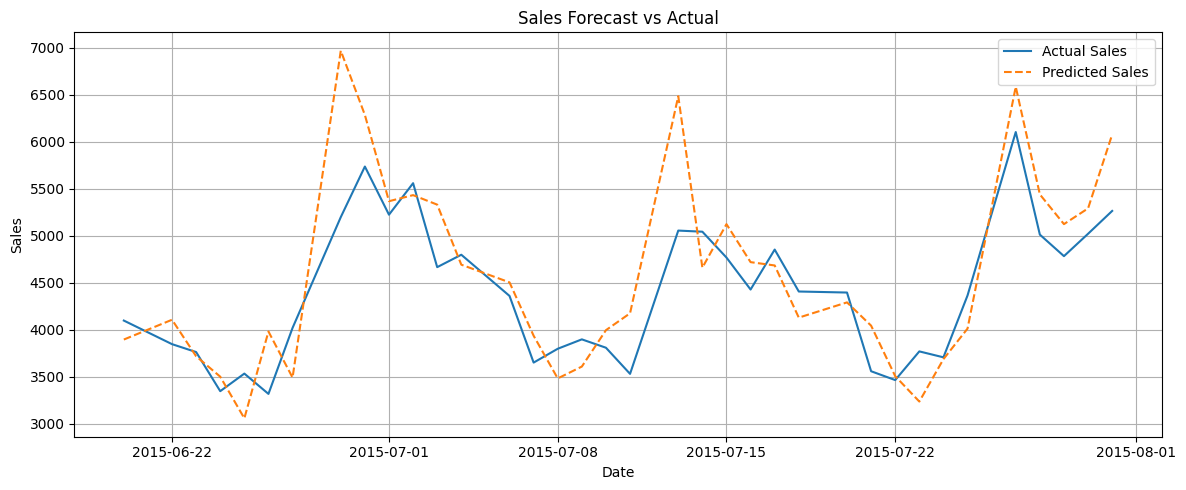

In [29]:
import matplotlib.pyplot as plt

val_set['Predicted'] = blended_val_preds
sample_store = val_set[val_set['Store'] == val_set['Store'].iloc[0]]

plt.figure(figsize=(12, 5))
plt.plot(sample_store['Date'], sample_store['Sales'], label='Actual Sales')
plt.plot(sample_store['Date'], sample_store['Predicted'], label='Predicted Sales', linestyle='--')
plt.title('Sales Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
# XGBoost validation prediction
val_preds_xgb = xgb_model.predict(xgb.DMatrix(val_set[features]))

# CatBoost validation prediction
val_preds_cat = cat_model.predict(val_set[features])

# Blend predictions (50% each)
val_preds = 0.5 * val_preds_xgb + 0.5 * val_preds_cat


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(val_set['Sales'], val_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(val_set['Sales'], val_preds)

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAE: {mae:.2f}")

Validation RMSE: 1066.69
Validation MAE: 757.49
